# Parse data structure into a pandas DataFrame
Parse data paths from the Smart-Kages folder structure and store them in a pandas DataFrames.

Also, load time adjustments to help estimate start and end times for each 1-hour segment.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sleap_io as sio

from smart_kages_movement.datetime import (
    extract_datetimes,
    find_segment_overlaps,
)
from smart_kages_movement.io import parse_data_into_df

## Configuration
Define some global variables and paths.

In [3]:
# Path to the data directory containing all kages.
data_dir = Path.home() / "Data" / "Smart-Kages"
assert data_dir.exists(), f"Data directory {data_dir} does not exist."

# Path for saving the processed data (in this case, a subfolder of 'data_dir').
save_dir = data_dir / "movement_analysis"
save_dir.mkdir(parents=True, exist_ok=True)

## Aggregate segment paths into a single dataframe

The data is stored per Smart-Kage, in folders names as `kageN`, e.g. `kage1`, `kage2`, etc.

Each Smart-Kage folder contains:
- daily videos are stored in `videos/YYYY/MM/DD/`, split into 1-hour segments. Each 1-hour segment is an `.mp4` file named `kageN_YYYYMMDD_HHMMSS.mp4`.
- corresponding DeepLabCut (DLC) predictions are stored in `analysis/dlc_output/YYYY/MM/DD/`. Each 1-hour `.h5` file therein is prefixed with `kageN_YYYYMMDD_HHMMSS`.

Let's parse the relevant parts of the data structure into a single dataframe.

In [4]:
df = parse_data_into_df(data_dir)
df.head()

Found 2 kage directories:  kage1 kage3
Found a total of 1615 .h5 pose files output by DLC.


start_datetime  \
kage  date     hour                       
kage1 20240403 09   2024-04-03 09:54:20   
               10   2024-04-03 10:00:02   
               11   2024-04-03 11:01:03   
               12   2024-04-03 12:01:04   
               13   2024-04-03 13:01:03   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   

                                                       video_file_path  
kage  date     hour                                                     
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...

## Add some video metadata
We reach each video's `n_frames`, `height`, `width`, and `n_channels` from the video file itself, using `sleap-io`.

These metadata are added as columns to the dataframe.

In [5]:
video_shapes = pd.DataFrame(
    np.zeros((len(df), 4), dtype=int),
    index=df.index,
    columns=["n_frames", "height", "width", "n_channels"],
)

for idx, row in df.iterrows():
    video_path = row["video_file_path"]
    video = sio.load_video(video_path)  # Lazy-Load the video using sleap_io
    # Extract video shape information
    video_shapes.loc[idx, "n_frames"] = video.shape[0]
    video_shapes.loc[idx, "height"] = video.shape[1]
    video_shapes.loc[idx, "width"] = video.shape[2]
    video_shapes.loc[idx, "n_channels"] = (
        video.shape[3] if len(video.shape) > 3 else 1
    )
    video.close()  # Close the video to free resources

# Concatenate the video shapes with the original DataFrame
df = pd.concat([df, video_shapes], axis=1)

Let's see if there are any videos where `n_channels` is not 3, which would indicate a non-RGB video.

In [6]:
df_non_rgb = df[df["n_channels"] != 3]
print(f"Founcd {len(df_non_rgb)} non-RGB videos.")
df_non_rgb.head(len(df_non_rgb))

Founcd 7 non-RGB videos.


start_datetime  \
kage  date     hour                       
kage1 20240403 11   2024-04-03 11:01:03   
      20240404 04   2024-04-04 04:01:04   
               06   2024-04-04 06:01:03   
kage3 20240411 02   2024-04-11 02:00:02   
      20240415 14   2024-04-15 14:00:57   
      20240418 18   2024-04-18 18:01:03   
      20240501 15   2024-05-01 15:04:45   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
      20240404 04    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               06    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
kage3 20240411 02    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   
      20240415 14    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   
      20240418 18    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   
      20240501 15    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   

                                                       video_file_path  \
kage  date     hour                                                      
kage1 20240403 11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
      20240404 04    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               06    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
kage3 20240411 02    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...   
      20240415 14    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...   
      20240418 18    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...   
      20240501 15    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...   

                     n_frames  height  width  n_channels  
kage  date     hour                                       
kage1 20240403 11        7064     376    500           1  
      20240404 04        7023     376    500           1  
               06        7019     376    500           1  
kage3 20240411 02        7163     376    500           1  
      20240415 14        7066     376    500           1  
      20240418 18        7046     376    500           1  
      20240501 15        6613     376    500           1

## Adjust datetimes for each segment
Above, we derived the start datetime of each video from its filename.
However, this is usually not the exact time when the video started recording.

We can find the exact start time for each video, as well as the exact timestamps for each frame, by inspecting two sources:

1. The `adjustments.txt` file. There is one per day, stored in `kageN/videos/YYYY/MM/DD/`, and contains one row per video file, formatted as `video_file:H,M,S`. For example, this could be `kage1_20240420_000002.mp4:0,0,6`. The hours, minutes, and seconds represent the offset relative to time `00:00:00` of that day. These values are extracted from the first video frame using computer vision. Negative, or otherwise impossible values indicate an error in this extraction process.

2. The `corrected_timestamps.pkl` file. There is one per day, stored in `kageN/analysis/dlc_output/YYYY/MM/DD/`. This file contains a dictionary mapping each pose filename to an array of corrected timestamps, expressed in seconds since the start of the hour. The first element should match the offset in the `adjustments.txt` file, and the rest should be derived by adding the frame timestamps (extracted from the .mp4 file) to this offset.

As a result of this process, the dataframe `df` will now have a `start_datetime` column with the exact start time of each video. Moreover, we will obtain a `frame_timestamps` dictionary, mapping each video segment, identified by a `(kage, date, hour)` tuple, to an array of timestamps expressed in seconds elapsed since the start of each video.

In [7]:
df, frame_timestamps = extract_datetimes(df)

/var/folders/w3/q74_bsm5379bzb0hkt1n4bzm0000gn/T/ipykernel_77261/2965125456.py:1: UserWarning: First timestamp for kage1_20240420_070002DLC_resnet101_v2Jan17shuffle2_580000.h5 does not match the adjustment for kage1_20240420_070002.mp4. Setting start_datetime to NaT.
  df, frame_timestamps = extract_datetimes(df)
/var/folders/w3/q74_bsm5379bzb0hkt1n4bzm0000gn/T/ipykernel_77261/2965125456.py:1: UserWarning: First timestamp for kage3_20240404_040103DLC_resnet101_v2Jan17shuffle2_580000.h5 does not match the adjustment for kage3_20240404_040103.mp4. Setting start_datetime to NaT.
  df, frame_timestamps = extract_datetimes(df)
/var/folders/w3/q74_bsm5379bzb0hkt1n4bzm0000gn/T/ipykernel_77261/2965125456.py:1: UserWarning: First timestamp for kage3_20240422_070002DLC_resnet101_v2Jan17shuffle2_580000.h5 does not match the adjustment for kage3_20240422_070002.mp4. Setting start_datetime to NaT.
  df, frame_timestamps = extract_datetimes(df)
/var/folders/w3/q74_bsm5379bzb0hkt1n4bzm0000gn/T/ipyker

Some warnings may have appeared during the adjustment, flagging invalid adjustments values or mismatches between the `adjustments.txt` and the `corrected_timestamps.pkl`. We have marked all such problematic segments as having a `start_datetime` of `NaT` (Not a Time) in the dataframe.

In [8]:
invalid_datetimes = df[df["start_datetime"].isna()]
if not invalid_datetimes.empty:
    print(
        f"Found {len(invalid_datetimes)} videos with invalid adjustments ",
        "or mismatched between the adjustment and corrected_timestamps.pkl.",
    )
else:
    print("All videos have valid start_datetimes.")

invalid_datetimes[["start_datetime"]]

Found 7 videos with invalid adjustments  or mismatched between the adjustment and corrected_timestamps.pkl.


start_datetime
kage  date     hour               
kage1 20240420 07              NaT
kage3 20240404 04              NaT
      20240422 07              NaT
      20240423 07              NaT
      20240425 07              NaT
      20240504 07              NaT
      20240506 07              NaT

We can open the first frame of each problematic video and look at the timestamps burned into the top-left corner.

('kage1', '20240420', '07')


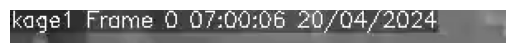

('kage3', '20240404', '04')


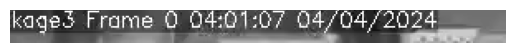

('kage3', '20240422', '07')


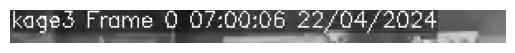

('kage3', '20240423', '07')


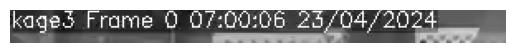

('kage3', '20240425', '07')


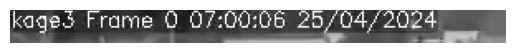

('kage3', '20240504', '07')


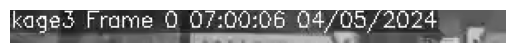

('kage3', '20240506', '07')


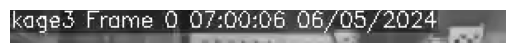

In [9]:
for idx, row in invalid_datetimes.iterrows():
    video_path = row["video_file_path"]
    video = sio.load_video(video_path)
    first_frame = video[0]  # Get the first frame
    # matplotlib show the first frame
    plt.imshow(first_frame[:20, :300])
    plt.axis("off")
    print(idx)
    plt.show()

Below, we will manually enter the correct start datetimes for each problematic video,
as a dictionary mapping `(kage, date, hour)` tuples to datetimes in the format `YYYY-MM-DD HH:MM:SS`.

In [10]:
manual_start_datetimes = {
    ("kage1", "20240420", "07"): "2024-04-20 07:00:06",
    ("kage3", "20240404", "04"): "2024-04-04 04:01:07",
    ("kage3", "20240422", "07"): "2024-04-22 07:00:06",
    ("kage3", "20240423", "07"): "2024-04-23 07:00:06",
    ("kage3", "20240425", "07"): "2024-04-25 07:00:06",
    ("kage3", "20240504", "07"): "2024-05-04 07:00:06",
    ("kage3", "20240506", "07"): "2024-05-06 07:00:06",
}

for (kage, date, hour), start_datetime in manual_start_datetimes.items():
    df.loc[(kage, date, hour), "start_datetime"] = pd.to_datetime(
        start_datetime, format="%Y-%m-%d %H:%M:%S"
    )

# All start datetimes should now be valid.
assert df["start_datetime"].notna().all(), "Some start datetimes are still NaT"

Now we can derive the precise datetime timestamps for each frame by adding the 
known `start_datetime` to the frame timestamps (which are in seconds elapsed).

We can also derive the `end_datetime` for each video as the last timestamp.

We also derive a `timestamps_datetime` dictionary, mapping each video segment, identified by a `(kage, date, hour)` tuple, to an array of precise datetime objects for each frame.

In [11]:
df["end_datetime"] = df["start_datetime"].copy()
timestamps_datetime = {}
for (kage, date, hour), seconds_elapsed in frame_timestamps.items():
    start_datetime = df.loc[(kage, date, hour), "start_datetime"]
    timedelta = pd.to_timedelta(seconds_elapsed, unit="s")
    datetime_stamps = start_datetime + timedelta
    # Derive the end datetimes from the last timestamp of each video.
    df.loc[(kage, date, hour), "end_datetime"] = datetime_stamps[-1]
    timestamps_datetime[(kage, date, hour)] = datetime_stamps

# Reorder columns for readability
df = df[
    [
        "start_datetime",
        "end_datetime",
        "n_frames",
        "n_channels",
        "height",
        "width",
        "pose_file_path",
        "video_file_path",
    ]
]
df.head()

start_datetime                  end_datetime  \
kage  date     hour                                                     
kage1 20240403 09   2024-04-03 09:54:24 2024-04-03 09:59:59.495354911   
               10   2024-04-03 10:00:06 2024-04-03 10:59:59.506997932   
               11   2024-04-03 11:01:07 2024-04-03 11:59:59.505496638   
               12   2024-04-03 12:01:08 2024-04-03 12:59:59.510819259   
               13   2024-04-03 13:01:07 2024-04-03 13:59:59.509458847   

                     n_frames  n_channels  height  width  \
kage  date     hour                                        
kage1 20240403 09         665           3     376    500   
               10        7183           3     376    500   
               11        7064           1     376    500   
               12        7059           3     376    500   
               13        7058           3     376    500   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   

                                                       video_file_path  
kage  date     hour                                                     
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...

Let's find out if there are any overlapping segments based on the `start_datetime` and `end_datetime`.

In [12]:
overlaps = find_segment_overlaps(df)
overlaps

Found 8 overlapping segments.


,segment_A,segment_B,start_A,end_A,start_B,end_B,overlap_duration_seconds
0,"(kage1, 20240426, 07)","(kage1, 20240426, 08)",2024-04-26 07:05:05,2024-04-26 08:04:59.485702530,2024-04-26 08:00:06,2024-04-26 08:59:59.485578567,293.485703
1,"(kage1, 20240427, 07)","(kage1, 20240427, 08)",2024-04-27 07:06:06,2024-04-27 08:05:59.487687713,2024-04-27 08:00:06,2024-04-27 08:59:59.481167180,353.487688
2,"(kage1, 20240428, 07)","(kage1, 20240428, 08)",2024-04-28 07:06:06,2024-04-28 08:05:59.481928075,2024-04-28 08:00:06,2024-04-28 09:00:00.486331762,353.481928
3,"(kage1, 20240429, 07)","(kage1, 20240429, 08)",2024-04-29 07:06:06,2024-04-29 08:05:59.484759121,2024-04-29 08:00:06,2024-04-29 08:59:59.486046362,353.484759
4,"(kage1, 20240430, 07)","(kage1, 20240430, 08)",2024-04-30 07:05:05,2024-04-30 08:04:59.485851968,2024-04-30 08:00:06,2024-04-30 08:59:59.483359875,293.485852
5,"(kage1, 20240502, 07)","(kage1, 20240502, 08)",2024-05-02 07:07:07,2024-05-02 08:07:00.469248101,2024-05-02 08:00:06,2024-05-02 08:59:59.507468044,414.469248
6,"(kage1, 20240505, 07)","(kage1, 20240505, 08)",2024-05-05 07:09:09,2024-05-05 08:09:02.484694039,2024-05-05 08:00:06,2024-05-05 08:59:59.485905783,536.484694
7,"(kage1, 20240507, 07)","(kage1, 20240507, 08)",2024-05-07 07:08:08,2024-05-07 08:08:01.486048507,2024-05-07 08:00:06,2024-05-07 08:59:59.485669554,475.486049


We suspect that these overlaps might be due to incorrect adjustments  for the videos mentioned in `segment_A`, i.e. the timestamps of the first frame being incorrectly read by the computer vision algorithm. We can confirm this and manually correct this, as we did above.

('kage1', '20240426', '07')


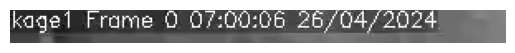

('kage1', '20240427', '07')


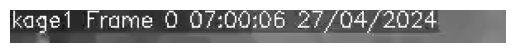

('kage1', '20240428', '07')


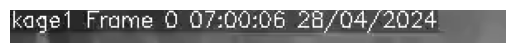

('kage1', '20240429', '07')


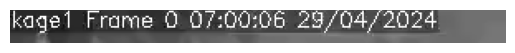

('kage1', '20240430', '07')


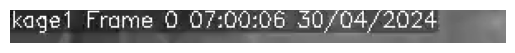

('kage1', '20240502', '07')


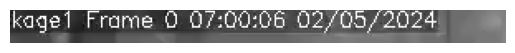

('kage1', '20240505', '07')


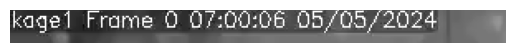

('kage1', '20240507', '07')


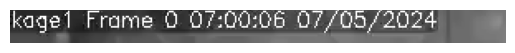

In [13]:
for _, row in overlaps.iterrows():
    segment_A = row["segment_A"]
    video_path = df.loc[segment_A, "video_file_path"]
    video = sio.load_video(video_path)
    first_frame = video[0]  # Get the first frame
    # matplotlib show the first frame
    plt.imshow(first_frame[:20, :300])
    plt.axis("off")
    print(segment_A)
    plt.show()

In [14]:
more_manual_start_datetimes = {
    ("kage1", "20240426", "07"): "2024-04-26 07:00:06",
    ("kage1", "20240427", "07"): "2024-04-27 07:00:06",
    ("kage1", "20240428", "07"): "2024-04-28 07:00:06",
    ("kage1", "20240429", "07"): "2024-04-29 07:00:06",
    ("kage1", "20240430", "07"): "2024-04-30 07:00:06",
    ("kage1", "20240502", "07"): "2024-05-02 07:00:06",
    ("kage1", "20240505", "07"): "2024-05-05 07:00:06",
    ("kage1", "20240507", "07"): "2024-05-07 07:00:06",
}

for (kage, date, hour), start_datetime in more_manual_start_datetimes.items():
    df.loc[(kage, date, hour), "start_datetime"] = pd.to_datetime(
        start_datetime, format="%Y-%m-%d %H:%M:%S"
    )
    start = pd.Timestamp(start_datetime)
    timedelta = pd.to_timedelta(frame_timestamps[(kage, date, hour)], unit="s")
    timestamps_datetime[(kage, date, hour)] = start + timedelta
    df.loc[(kage, date, hour), "end_datetime"] = timestamps_datetime[
        (kage, date, hour)
    ][-1]

Everything should be fine now, but let's run some sanity checks

In [18]:
# All start datetimes should now be valid.
assert df["start_datetime"].notna().all(), "Some start datetimes are still NaT"

# Now, there should be no more overlaps
overlaps = find_segment_overlaps(df)
assert overlaps is None, (
    "There are still overlapping segments after manual adjustments."
)

# For each kage, the start_datetime values should be monotonic increasing
for kage in df.index.get_level_values("kage").unique():
    kage_start_datetimes = df.loc[kage, "start_datetime"].values
    assert np.all(np.diff(kage_start_datetimes) >= pd.Timedelta(0)), (
        f"Start datetimes for kage {kage} are not monotonic increasing."
    )

# For each row, the end_datetime should be greater than the start_datetime
assert np.all(df["end_datetime"] > df["start_datetime"]), (
    "Some end datetimes are not greater than start datetimes."
)

No overlapping segments found.


## Save the timestamps to txt files
We save the datetime timestamps to .txt files, with one file per 1-hour video segment.

We also store the paths to these .txt files in the `df` dataframe, in a new column called `timestamps_path`.

In [19]:
timestamps_dir = save_dir / "timestamps"
timestamps_dir.mkdir(parents=True, exist_ok=True)

for (kage, date, hour), stamps in timestamps_datetime.items():
    # Format timestamps as ISO strings and save
    iso_stamps = stamps.strftime("%Y-%m-%dT%H:%M:%S.%f")
    timestamps_path = timestamps_dir / f"{kage}_{date}_{hour}_timestamps.txt"
    np.savetxt(timestamps_path, iso_stamps, fmt="%s")
    # Also add the path to the saved timestamps to the DataFrame
    df.loc[(kage, date, hour), "timestamps_file_path"] = timestamps_path

print(f"Timestamps saved to {timestamps_dir}.")

Timestamps saved to /Users/nsirmpilatze/Data/Smart-Kages/movement_analysis/timestamps.


## Save the dataframes as CSV files
Finally, we save the `df` dataframe to a CSV file for later use.

In [20]:
df.to_csv(save_dir / "all_segments.csv")
print(f"Dataframe saved to {save_dir}.")

Dataframe saved to /Users/nsirmpilatze/Data/Smart-Kages/movement_analysis.
